# Gaussian mixture model training

In [1]:
# !mkdir -p data
# !wget -O data/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
# !wget -O data/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
# !tar -xf data/train.tar -C data
# !tar -xf data/test.tar -C data

In [2]:
# !pip install lightning

In [ ]:
import os
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, deeplabv3_resnet50
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

from enum import IntEnum
from typing import Optional

In [4]:
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "../data"
CHECKPOINTS_DIR = "./checkpoints"

## Imports

In [5]:
class StreetHazardsClasses(IntEnum):
    UNLABELED       = 0
    BUILDING        = 1
    FENCE           = 2
    OTHER           = 3
    PEDESTRIAN      = 4
    POLE            = 5
    ROAD_LINE       = 6
    ROAD            = 7
    SIDEWALK        = 8
    VEGETATION      = 9
    CAR             = 10
    WALL            = 11
    TRAFFIC_SIGN    = 12
    ANOMALY         = 13


class StreetHazardsDataset(Dataset):
    def __init__(
        self,
        odgt_path: str,
        more_transforms1 = None,
        more_transforms2 = None,
        random_crop_size: Optional[tuple[int, int]] = None
    ):
        with open(odgt_path, "r") as f:
            odgt_data = json.load(f)

        self.paths = [
            {
                "image": os.path.join(Path(odgt_path).parent, data["fpath_img"]),
                "annotation": os.path.join(Path(odgt_path).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
        
        self.image_transforms = transforms.Compose([ transforms.ToTensor() ])
        self.more_transforms1 = more_transforms1 if more_transforms1 is not None else (lambda x: x)
        self.more_transforms2 = more_transforms2 if more_transforms2 is not None else (lambda x: x)

        self.random_crop_size = random_crop_size

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        annotation = Image.open(self.paths[idx]["annotation"])

        # Apply transforms
        image = self.image_transforms(image)
        image = self.more_transforms1(image)
        annotation = torch.as_tensor(transforms.functional.pil_to_tensor(annotation), dtype=torch.int64) - 1 # Make class indexes start from 0
        annotation = self.more_transforms2(annotation).squeeze(0)

        if self.random_crop_size is not None:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.random_crop_size)
            image = transforms.functional.crop(image, i, j, h, w)
            annotation = transforms.functional.crop(annotation, i, j, h, w)
            
        return image, annotation

    def __len__(self):
        return len(self.paths)



COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
])

def visualize_annotation(annotation_img: np.ndarray|torch.Tensor, ax=None):
    """
    Adapted from https://github.com/CVLAB-Unibo/ml4cv-assignment/blob/master/utils/visualize.py
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(img: np.ndarray|torch.Tensor, ax=None):
    if ax is None: ax = plt.gca()
    img = np.asarray(img)
    ax.imshow(np.moveaxis(img, 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
class AccumulatorMIoU:
    """
    Adapted from https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/metrics/stream_metrics.py
    """
    def __init__(self, num_classes, anomaly_index):
        self.num_classes = num_classes
        self.anomaly_index = anomaly_index if anomaly_index is not None else -1
        self.reset()

    def _fast_hist(self, preds, labels):
        mask = (labels >= 0) & (labels != self.anomaly_index)
        hist = np.bincount(
            self.num_classes * labels[mask].type(torch.int32) + preds[mask],
            minlength = self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist
    
    def add(self, preds, labels):
        if preds.dim() == 2: preds = preds.unsqueeze(0)
        if labels.dim() == 2: labels = labels.unsqueeze(0)
        preds, labels = preds.cpu(), labels.cpu()
        for p, l in zip(preds, labels):
            self.confusion_matrix += self._fast_hist( p.flatten(), l.flatten() )

    def compute(self):
        hist = self.confusion_matrix
        with np.errstate(divide="ignore", invalid="ignore"):
            iou_c = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iou = np.nanmean(iou_c)
        return mean_iou
    
    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

In [7]:
class BaseSegmenterAndDetector:
    def __init__(self):
        super().__init__()

        
    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            segmentation (torch.Tensor): (B x C x H x W) tensor with the raw predictions for segmentation.
            anomaly (torch.Tensor): (B x 1 x H x W) tensor with the raw predictions for anomaly.
        """
        raise NotImplementedError()

In [8]:
class PretrainedSegmenter(L.LightningModule):
    def __init__(self, optimizer_args: dict, image_size: Optional[tuple[int, int]]=None, num_classes: int=len(StreetHazardsClasses)-1):
        super().__init__()
        self.model = None
        self.image_size = image_size
        self.num_classes = num_classes
        self.optimizer_args = optimizer_args
        self.train_miou_acc = AccumulatorMIoU(num_classes, None)
        self.val_miou_acc = AccumulatorMIoU(num_classes, None)


    def _forward(self, images) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Returns:
            logits
            hidden_states (if any)
        """
        raise NotImplementedError()


    def forward(self, images, return_hidden_states=False):
        if self.image_size:
            original_shape = (images.shape[2], images.shape[3])
            images = F.interpolate(images, self.image_size, mode="bilinear")

        logits, hidden_states = self._forward(images)

        if self.image_size:
            logits = F.interpolate(logits, original_shape, mode="bilinear")

        return (logits, hidden_states) if return_hidden_states else logits


    def get_hidden_sizes(self):
        raise NotImplementedError()
    

    @staticmethod
    def get(model_name: str, optimizer_args: dict={}, image_size: Optional[tuple[int, int]]=None, num_classes: int=len(StreetHazardsClasses)-1):
        match model_name:
            case "deeplabv3_mobilenet":
                return _PretrainedPytorchSegmenter(model_name, optimizer_args, image_size, num_classes)
            case "deeplabv3_resnet50":
                return _PretrainedPytorchSegmenter(model_name, optimizer_args, image_size, num_classes)
            case _:
                return _PretrainedHuggingFaceSegmenter(model_name, optimizer_args, image_size, num_classes)


    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), **self.optimizer_args)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)

        self.train_miou_acc.add(torch.argmax(logits, dim=1), labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)

        self.val_miou_acc.add(torch.argmax(logits, dim=1), labels)
        self.log("val_loss", loss)
        return loss

    def on_train_epoch_end(self):
        self.log("train_miou", self.train_miou_acc.compute())
        self.log("val_miou", self.val_miou_acc.compute())
        metrics = self.trainer.callback_metrics

        print(
            f"Epoch {self.current_epoch} --- train_loss: {metrics['train_loss'].item():.4f} -- val_loss: {metrics['val_loss'].item():.4f}"
            f" | train_miou: {metrics['train_miou'].item():.4f} -- val_miou: {metrics['val_miou'].item():.4f}"
        )

        self.train_miou_acc.reset()
        self.val_miou_acc.reset()



class _PretrainedPytorchSegmenter(PretrainedSegmenter):
    def __init__(self, model_name: str, optimizer_args: dict, image_size: Optional[tuple[int, int]]=None, num_classes: int=len(StreetHazardsClasses)-1):
        super().__init__(optimizer_args, image_size, num_classes)
        match model_name:
            case "deeplabv3_mobilenet":
                self.model = deeplabv3_mobilenet_v3_large(num_classes=num_classes)
            case "deeplabv3_resnet50":
                self.model = deeplabv3_resnet50(num_classes=num_classes)
            case _:
                raise NotImplementedError("Model not available")

    def _forward(self, images):
        outputs = self.model(images)
        logits = outputs["out"]
        return logits, None
        
    def get_hidden_sizes(self):
        raise NotImplementedError()


class _PretrainedHuggingFaceSegmenter(PretrainedSegmenter):
    def __init__(self, model_name: str, optimizer_args: dict, image_size: Optional[tuple[int, int]]=None, num_classes: int=len(StreetHazardsClasses)-1):
        super().__init__(optimizer_args, image_size, num_classes)
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
        self.image_size = (self.model.config.image_size, self.model.config.image_size)

    def _forward(self, images):
        inputs = self.processor(images=images, return_tensors="pt", do_resize=False, do_rescale=False).to(self.model.device)
        outputs = self.model(
            **inputs,
            output_hidden_states = True
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states

        return logits, hidden_states
        
    def get_hidden_sizes(self):
        return self.model.config.neck_hidden_sizes[:-1]


In [9]:
class GaussianMixtureDensityNetwork(torch.nn.Module):
    def __init__(self, emb_size: int, num_gaussians: int):
        """
        Gaussian mixture model for image embeddings.

        Args:
            emb_size (int): Dimensionality of the input embeddings.
            num_gaussians (int): Number of Gaussian components
        """
        super().__init__()
        self.emb_size = emb_size
        self.num_gaussians = num_gaussians
        self.proj_weights = nn.Linear(emb_size, num_gaussians, bias=False)
        self.proj_means = nn.Linear(emb_size, num_gaussians*emb_size, bias=False)
        self.proj_variances = nn.Linear(emb_size, num_gaussians*emb_size, bias=False)


    def forward(self, inputs):
        """
        Args:
            inputs (torch.Tensor): (B x P x emb_size) where P is the flattened spatial dimension of the image.
        """
        batch_size = inputs.shape[0]
        num_patches = inputs.shape[1]

        weights = F.softmax(self.proj_weights(inputs), dim=-1)
        means = self.proj_means(inputs).view(batch_size, num_patches, self.emb_size, self.num_gaussians)
        logvars = F.softplus(self.proj_variances(inputs)).view(batch_size, num_patches, self.emb_size, self.num_gaussians)
        
        return weights, means, logvars
        

    @staticmethod
    def loss(x, weights, means, logvars, reduction="none"):
        x = x.unsqueeze(-1).expand_as(logvars)
        log_probs = -1 * Normal(means, torch.exp(logvars)).log_prob(x).mean(2) # Aggregate emb_size. Mean is better to uniform varying sizes.
        log_gmm = (weights * log_probs).sum(2)

        match reduction:
            case "none":
                return log_gmm
            case "mean":
                return torch.mean( torch.mean(log_gmm, 1) )

In [10]:
def _reshape_latent_for_mdn(latents):
    """
    Reshapes a latent from (B x hidden_size x H x W) to (B x flat_spatial_dimension x hidden_size)
    """
    latents = torch.permute(latents, (0, 2, 3, 1))
    latents = torch.flatten(latents, start_dim=1, end_dim=2)
    return latents

def _reshape_probs_as_image(probs):
    """
    Reshapes a probability map from (B x flat_spatial_dimension) to (B x 1 x H x W).
    The image is assumed to be a square.
    """
    probs = probs.reshape(probs.shape[0], 1, int(np.sqrt(probs.shape[1])), int(np.sqrt(probs.shape[1])))
    return probs



class SegmenterMDN(BaseSegmenterAndDetector, L.LightningModule):
    def __init__(self, segmenter: PretrainedSegmenter, num_gaussians: int, optimizer_args={}, num_classes=len(StreetHazardsClasses)-1):
        super().__init__()
        self.segmenter = segmenter
        self.mdn = GaussianMixtureDensityNetwork(self.segmenter.get_hidden_sizes()[-1], num_gaussians)
        self.optimizer_args = optimizer_args
        self.train_miou_acc = AccumulatorMIoU(num_classes, None)
        self.val_miou_acc = AccumulatorMIoU(num_classes, None)


    def configure_optimizers(self):
        return torch.optim.AdamW([*self.segmenter.parameters(), *self.mdn.parameters()], **self.optimizer_args)

    def segmenter_requires_grad(self, requires_grad):
        self.segmenter.requires_grad_(requires_grad)
        self.segmenter.train() if requires_grad else self.segmenter.eval()
        self.train_segm = requires_grad

    def mdn_requires_grad(self, requires_grad):
        self.mdn.requires_grad_(requires_grad)
        self.mdn.train() if requires_grad else self.mdn.eval()
        self.train_mdn = requires_grad
    

    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        segm_logits, hidden_states = self.segmenter(inputs, return_hidden_states=True)
        latents = _reshape_latent_for_mdn(hidden_states[-1])
        weights, means, logvars = self.mdn(latents)
        anom_log_probs = GaussianMixtureDensityNetwork.loss(latents, weights, means, logvars, reduction="none")
        anom_log_probs = _reshape_probs_as_image(anom_log_probs)
        anom_log_probs = F.interpolate(anom_log_probs, size=(inputs.shape[2], inputs.shape[3]), mode="bilinear")
        return segm_logits, anom_log_probs


    def __train_forward(self, images):
        semg_logits, hidden_states = self.segmenter(images, return_hidden_states=True)
        latents = _reshape_latent_for_mdn(hidden_states[-1])
        weights, means, logvars = self.mdn(latents) if self.train_mdn else (0, 0, 0)
        return semg_logits, latents, weights, means, logvars

    def __loss(self, labels, segm_logits, latents, weights, means, logvars):
        loss_ce = F.cross_entropy(segm_logits, labels)
        loss_likelihood = GaussianMixtureDensityNetwork.loss(latents, weights, means, logvars, reduction="mean") if self.train_mdn else 0
        loss = 0
        if self.train_segm: loss += loss_ce
        if self.train_mdn: loss += loss_likelihood
        return loss, loss_ce, loss_likelihood

    def training_step(self, batch, batch_idx):
        images, labels = batch
        semg_logits, latents, weights, means, logvars = self.__train_forward(images)
        loss, loss_ce, loss_likelihood = self.__loss(labels, semg_logits, latents, weights, means, logvars)
        
        self.train_miou_acc.add(torch.argmax(semg_logits, dim=1), labels)
        self.log("train_ce", loss_ce)
        self.log("train_ll", loss_likelihood)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        semg_logits, latents, weights, means, logvars = self.__train_forward(images)
        loss, loss_ce, loss_likelihood = self.__loss(labels, semg_logits, latents, weights, means, logvars)
        
        self.val_miou_acc.add(torch.argmax(semg_logits, dim=1), labels)
        self.log("val_ce", loss_ce)
        self.log("val_ll", loss_likelihood)
        self.log("val_loss", loss)
        return loss


    def on_train_epoch_end(self):
        self.log("train_miou", self.train_miou_acc.compute())
        self.log("val_miou", self.val_miou_acc.compute())
        metrics = self.trainer.callback_metrics

        print(
            f"Epoch {self.current_epoch} --- train_loss: {metrics['train_loss'].item():.4f} -- val_loss: {metrics['val_loss'].item():.4f}"
            f" | train_ce: {metrics['train_ce'].item():.4f} -- val_ce: {metrics['val_ce'].item():.4f}"
            f" | train_miou: {metrics['train_miou'].item():.4f} -- val_miou: {metrics['val_miou'].item():.4f}"
            f" | train_ll: {metrics['train_ll'].item():.4f} -- val_ll: {metrics['val_ll'].item():.4f}"
        )

        self.train_miou_acc.reset()
        self.val_miou_acc.reset()

## Dataset preparation

torch.Size([3, 512, 512])


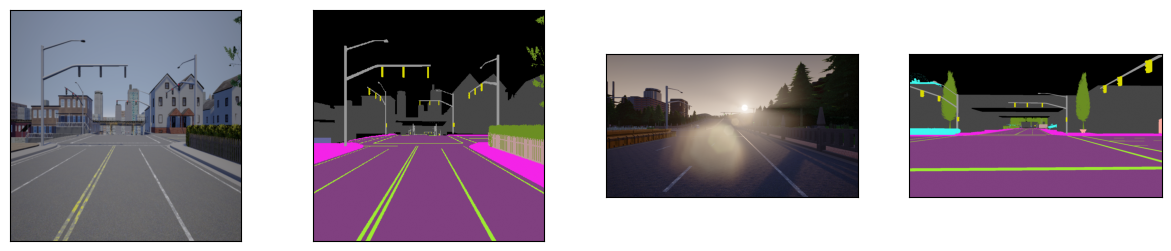

In [11]:
IMAGE_SIZE = (720, 1280)

more_transforms1 = transforms.Compose([ transforms.Resize((512, 512), transforms.InterpolationMode.BILINEAR) ])
more_transforms2 = transforms.Compose([ transforms.Resize((512, 512), transforms.InterpolationMode.NEAREST) ])


ds_train = StreetHazardsDataset(
    os.path.join(DATA_DIR, "train/train.odgt"),
    more_transforms1 = more_transforms1,
    more_transforms2 = more_transforms2,
    # random_crop_size = (512, 512)
)
ds_val = StreetHazardsDataset( os.path.join(DATA_DIR, "train/validation.odgt") )
__ds_test = StreetHazardsDataset( os.path.join(DATA_DIR, "test/test.odgt") )


print(ds_train[0][0].shape)

train_sample = ds_train[0]
plt.figure(figsize=(15, 3))
plt.subplot(1, 4, 1)
visualize_scene(train_sample[0])
plt.subplot(1, 4, 2)
visualize_annotation(train_sample[1])
plt.subplot(1, 4, 3)
visualize_scene(ds_val[0][0])
plt.subplot(1, 4, 4)
visualize_annotation(__ds_test[0][1])
plt.show()

## Model preparation

In [ ]:
L.seed_everything(SEED, workers=True, verbose=False)

segmenter = PretrainedSegmenter.get("apple/deeplabv3-mobilevit-small")
segmenter.load_state_dict(torch.load("../weights/segmenter/deeplabv3-mobilevit-small-wd01-miou-noweights-resize.pt", weights_only=True))

model = SegmenterMDN(
    segmenter = segmenter,
    num_gaussians = 100,
    optimizer_args = { "lr": 1e-3, "weight_decay": 0.001 }
)

## Training

In [ ]:
L.seed_everything(SEED, workers=True, verbose=False)
trainer = L.Trainer(
    max_epochs = 30,
    logger = CSVLogger(os.path.join(CHECKPOINTS_DIR, "logs")),
    enable_checkpointing = True,
    deterministic = "warn",
    callbacks = [
        ModelCheckpoint(dirpath=CHECKPOINTS_DIR, save_top_k=1, monitor="val_loss", mode="min"),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    ]
)

In [ ]:
model.segmenter_requires_grad(False)
model.mdn_requires_grad(True)

trainer.fit(
    model, 
    DataLoader(ds_train, batch_size=4, shuffle=True, num_workers=2),
    DataLoader(ds_val, batch_size=4, shuffle=False, num_workers=2),
)

print(trainer.checkpoint_callback.best_model_path)
model.load_state_dict(torch.load(trainer.checkpoint_callback.best_model_path)["state_dict"])